In [265]:
# HOMEWORK 1
# Developed by Alberto Dian, Davide Nascivera and Yunju Li

import pandas as pd
from docplex.mp.model import Model  
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt

# Assign each product to its correct class considering the classes population thresholds on total class turnover 

In [266]:
# 1. Compute the turnover and assign each product to its correct class

# Read the CSV file

distances = pd.read_csv("input/distances.csv", index_col=0)
product_data = pd.read_csv("input/product_data.csv")

demand = product_data[['prod_id','Demand']].transpose().values
value = product_data[['prod_id','Value']].transpose().values
dist = distances['distance'].transpose().values
num_lines = len(product_data)

#compute the turnover for each product
turnover = demand[1]*value[1]

# Compute the total turnover
tot_turnover = np.sum(turnover)

# Compute the total demand
tot_demand = np.sum(demand[1])

# Compute the turnover in percentage values
percentage_turnover = (turnover/tot_turnover)*100

# Compute the demand in percentage values
percentage_demand = (demand[1]/tot_demand)*100

data = []

for i in range(num_lines):
    data.append((i,turnover[i], percentage_demand[i], percentage_turnover[i]))

In [267]:
# Sort the list considering the turnover percentage
sorted_data = sorted(data, key=lambda x: x[3], reverse=True)

# Compute the cumulative percentage of turnover
cum_turnover = 0
cum_demand = 0

for i in range(num_lines):
    cum_demand = sorted_data[i][2] + cum_demand
    cum_turnover = sorted_data[i][3] + cum_turnover
    sorted_data[i] = sorted_data[i] + (cum_turnover,) + (cum_demand,)

# Print the table with all the values
header = ["Product Id", "Absolute turnover", "Percentage Demand [%]","Percentage Turnover [%]", "Cumulative turnover [%]", "Cumulative demand [%]"]
print(tabulate(sorted_data, header))
print("Total turnover: ", tot_turnover)

  Product Id    Absolute turnover    Percentage Demand [%]    Percentage Turnover [%]    Cumulative turnover [%]    Cumulative demand [%]
------------  -------------------  -----------------------  -------------------------  -------------------------  -----------------------
           0                120                   18.4049                  42.4628                       42.4628                  18.4049
           3                 64                   19.6319                  22.6469                       65.1097                  38.0368
           8                 45                    9.20245                 15.9236                       81.0333                  47.2393
          10                 28                    8.58896                  9.908                        90.9413                  55.8282
           2                 16.8                 14.7239                   5.9448                       96.8861                  70.5521
           9                  3.2 

In [268]:
# Assignment of each product to its correct class
classA = 90
classB = 95
classC = 100

for i in range(len(sorted_data)):
    cumulative_turnover = sorted_data[i][4]

    if cumulative_turnover < classA:
        sorted_data[i] = sorted_data[i][:6] + ("A",)
    elif classA < cumulative_turnover < classB:
        sorted_data[i] = sorted_data[i][:6] + ("B",)
    else:
        sorted_data[i] = sorted_data[i][:6] + ("C",)

header = ["Product Id", "Absolute turnover", "Percentage Demand [%]", "Percentage Turnover [%]", "Cumulative turnover [%]", "Cumulative demand [%]", "Class"]
print(tabulate(sorted_data, header))

  Product Id    Absolute turnover    Percentage Demand [%]    Percentage Turnover [%]    Cumulative turnover [%]    Cumulative demand [%]  Class
------------  -------------------  -----------------------  -------------------------  -------------------------  -----------------------  -------
           0                120                   18.4049                  42.4628                       42.4628                  18.4049  A
           3                 64                   19.6319                  22.6469                       65.1097                  38.0368  A
           8                 45                    9.20245                 15.9236                       81.0333                  47.2393  A
          10                 28                    8.58896                  9.908                        90.9413                  55.8282  B
           2                 16.8                 14.7239                   5.9448                       96.8861                  70.5521  C
   

In [269]:
# Compute the Apc parameter

Apc = []
temp_data = sorted(sorted_data, key=lambda x: x[0])

for i in range(len(temp_data)):
    if temp_data[i][6] == 'A':
        Apc.append((1,0,0))
    elif temp_data[i][6] == 'B':
        Apc.append((0,1,0))
    else:
        Apc.append((0,0,1))

classes = ["A", "B", "C"]
print(tabulate(Apc, classes))

  A    B    C
---  ---  ---
  1    0    0
  0    0    1
  0    0    1
  1    0    0
  0    0    1
  0    0    1
  0    0    1
  0    0    1
  1    0    0
  0    0    1
  0    1    0


In [270]:
# 2. Solve the optimization problem in CPLEX
mdl_2 = Model(name="prod_storage_2")

In [271]:
# Define the parameters

C = 3 #number of classes
L = len(dist) #number of locations
tl = dist #travel distance from location l to single depot
Dp = product_data['Demand'].values #demand for each product
P = len(Dp) #number of products

In [272]:
# Define the decision variable
xlc = mdl_2.binary_var_matrix(L,C, name="x")

In [273]:
# Define the costraints

# At most one product class per location
for l in range(L):
    mdl_2.add_constraint(mdl_2.sum(xlc[l,c] for c in range(C)) <= 1)

# Storage capacity must be guaranteed for every class
for c in range(C):
    mdl_2.add_constraint(mdl_2.sum(Dp[p]*Apc[p][c] for p in range(P)) <= mdl_2.sum(xlc[l,c] for l in range(L)))

In [274]:
# Define the Objective function
mdl_2.minimize(mdl_2.sum(mdl_2.sum(tl[l]*xlc[l,c] for l in range(L)) * mdl_2.sum(Dp[p]*Apc[p][c] for p in range(P)) for c in range(C)))

In [275]:
print(mdl_2.export_to_string())
sol_2 = mdl_2.solve()

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: prod_storage_2

Minimize
 obj: 4620 x_0_0 + 840 x_0_1 + 4320 x_0_2 + 3465 x_1_0 + 630 x_1_1 + 3240 x_1_2
      + 2464 x_2_0 + 448 x_2_1 + 2304 x_2_2 + 1617 x_3_0 + 294 x_3_1
      + 1512 x_3_2 + 924 x_4_0 + 168 x_4_1 + 864 x_4_2 + 385 x_5_0 + 70 x_5_1
      + 360 x_5_2 + 154 x_6_0 + 28 x_6_1 + 144 x_6_2 + 77 x_7_0 + 14 x_7_1
      + 72 x_7_2 + 231 x_8_0 + 42 x_8_1 + 216 x_8_2 + 616 x_9_0 + 112 x_9_1
      + 576 x_9_2 + 1155 x_10_0 + 210 x_10_1 + 1080 x_10_2 + 1848 x_11_0
      + 336 x_11_1 + 1728 x_11_2 + 2695 x_12_0 + 490 x_12_1 + 2520 x_12_2
      + 3696 x_13_0 + 672 x_13_1 + 3456 x_13_2 + 4851 x_14_0 + 882 x_14_1
      + 4536 x_14_2 + 5621 x_15_0 + 1022 x_15_1 + 5256 x_15_2 + 4312 x_16_0
      + 784 x_16_1 + 4032 x_16_2 + 3157 x_17_0 + 574 x_17_1 + 2952 x_17_2
      + 2156 x_18_0 + 392 x_18_1 + 2016 x_18_2 + 1309 x_19_0 + 238 x_19_1
      + 1224 x_19_2 + 770 x_20_0 + 140 x_20_1 + 720 x_20_2 + 462 x_21_0
 

In [276]:
sol_2.display()

solution for: prod_storage_2
objective: 856125
status: OPTIMAL_SOLUTION(2)
x_0_0 = 1
x_1_0 = 1
x_2_0 = 1
x_3_0 = 1
x_4_0 = 1
x_5_0 = 1
x_6_0 = 1
x_7_0 = 1
x_8_0 = 1
x_9_0 = 1
x_10_0 = 1
x_11_0 = 1
x_12_0 = 1
x_13_0 = 1
x_14_0 = 1
x_15_0 = 1
x_16_0 = 1
x_17_0 = 1
x_18_0 = 1
x_19_0 = 1
x_20_0 = 1
x_21_0 = 1
x_22_0 = 1
x_23_0 = 1
x_24_0 = 1
x_25_0 = 1
x_26_0 = 1
x_27_0 = 1
x_28_0 = 1
x_29_0 = 1
x_30_2 = 1
x_31_0 = 1
x_32_0 = 1
x_33_0 = 1
x_34_0 = 1
x_35_0 = 1
x_36_0 = 1
x_37_0 = 1
x_38_0 = 1
x_39_0 = 1
x_40_0 = 1
x_41_0 = 1
x_42_0 = 1
x_43_0 = 1
x_44_2 = 1
x_45_2 = 1
x_46_2 = 1
x_47_0 = 1
x_48_0 = 1
x_49_0 = 1
x_50_0 = 1
x_51_0 = 1
x_52_0 = 1
x_53_0 = 1
x_54_0 = 1
x_55_0 = 1
x_56_0 = 1
x_57_0 = 1
x_58_2 = 1
x_59_2 = 1
x_60_2 = 1
x_61_2 = 1
x_62_2 = 1
x_63_0 = 1
x_64_0 = 1
x_65_0 = 1
x_66_0 = 1
x_67_0 = 1
x_68_0 = 1
x_69_0 = 1
x_70_0 = 1
x_71_0 = 1
x_72_2 = 1
x_73_2 = 1
x_74_2 = 1
x_75_2 = 1
x_76_2 = 1
x_77_2 = 1
x_78_2 = 1
x_79_0 = 1
x_80_0 = 1
x_81_0 = 1
x_82_0 = 1
x_83_0 = 1
x_84_0 = 1


In [277]:
for c in range(len(classes)):
        class_assigned_locations = [l+1 for l in range(L) if sol_2.get_value(xlc[l,c]) == 1]
        print(f"Class {classes[c]} Storage Locations: {class_assigned_locations}")

Class A Storage Locations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 64, 65, 66, 67, 68, 69, 70, 71, 72, 80, 81, 82, 83, 84, 85, 86, 96, 97, 98, 99, 100, 112, 113]
Class B Storage Locations: [121, 135, 136, 137, 138, 148, 149, 150, 152, 153, 154, 162, 163, 164]
Class C Storage Locations: [31, 45, 46, 47, 59, 60, 61, 62, 63, 73, 74, 75, 76, 77, 78, 79, 87, 88, 89, 90, 91, 92, 93, 94, 95, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 139, 140, 141, 142, 143, 144, 145, 146, 147, 155, 156, 157, 158, 159, 160, 161]


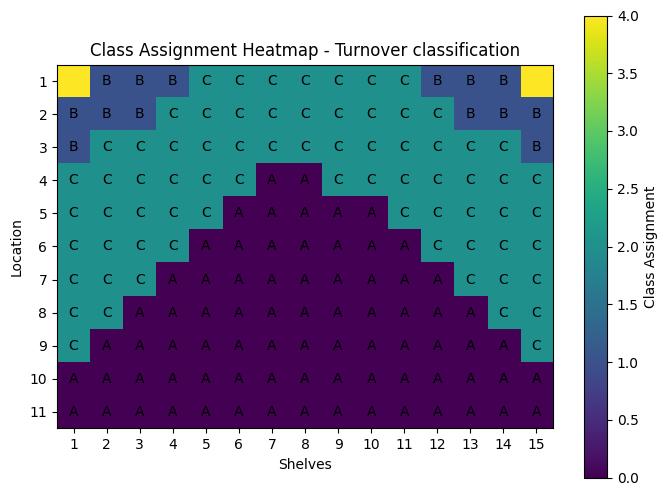

In [278]:
# Initialize a matrix to store class assignments for each station
class_matrix = np.zeros((11, 15), dtype=int)  # Assuming 11 shelves and 15 locations
tmp = 0

# Mapping dictionary for class indices to letters
class_letters = {0: 'A', 1: 'B', 2: 'C'}  # Add more mappings as needed

# Populate the class assignment matrix
for n in range(0, 11):  # assuming 11 shelves
    for m in range(0, 15):  # iterating through locations
        class_matrix[10 - n][m] = 4
        for c in range(len(classes)):
            if sol_2.get_value(xlc[tmp, c]) == 1:
                class_matrix[10 - n][m] = c  # Assign class index to matrix
        tmp += 1

# Create the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(class_matrix, cmap='viridis', interpolation='nearest')

# Add text annotations for class letters inside the cells
for i in range(11):
    for j in range(15):
        if class_matrix[i][j] in class_letters:
            plt.text(j, i, class_letters[class_matrix[i][j]], ha='center', va='center', color='black')

# Set axes labels
plt.xlabel('Shelves')
plt.ylabel('Location')

# Set colorbar
cbar = plt.colorbar()
cbar.set_label('Class Assignment')

# Set ticks for shelves and locations
plt.xticks(np.arange(15), np.arange(1, 16))
plt.yticks(np.arange(11), np.arange(1, 12))

plt.title('Class Assignment Heatmap - Turnover classification')
plt.show()



# Assign each product to its correct class considering the classes population thresholds on total class demand 

In [279]:
# Assign each product to its correct class considering the classes population thresholds on total class demand 

# Read the CSV file

distances = pd.read_csv("input/distances.csv", index_col=0)
product_data = pd.read_csv("input/product_data.csv")

demand = product_data[['prod_id','Demand']].transpose().values
value = product_data[['prod_id','Value']].transpose().values
dist = distances['distance'].transpose().values
num_lines = len(product_data)

#compute the turnover for each product
turnover = demand[1]*value[1]

# Compute the total turnover
tot_turnover = np.sum(turnover)

# Compute the total demand
tot_demand = np.sum(demand[1])

# Compute the turnover in percentage values
percentage_turnover = (turnover/tot_turnover)*100

# Compute the demand in percentage values
percentage_demand = (demand[1]/tot_demand)*100

data = []

for i in range(num_lines):
    data.append((i,turnover[i], percentage_demand[i], percentage_turnover[i]))
    


In [280]:
# Sort the list considering the turnover percentage
sorted_data = sorted(data, key=lambda x: x[2], reverse=True)

# Compute the cumulative percentage of turnover
cum_turnover = 0
cum_demand = 0
for i in range(num_lines):
    cum_demand = sorted_data[i][2] + cum_demand
    cum_turnover = sorted_data[i][3] + cum_turnover
    sorted_data[i] = sorted_data[i] + (cum_turnover,) + (cum_demand,)

# Print the table with all the values
header = ["Product Id", "Absolute turnover", "Percentage Demand [%]","Percentage Turnover [%]", "Cumulative turnover [%]", "Cumulative demand [%]"]
print(tabulate(sorted_data, header))
print("Total turnover: ", tot_turnover)


  Product Id    Absolute turnover    Percentage Demand [%]    Percentage Turnover [%]    Cumulative turnover [%]    Cumulative demand [%]
------------  -------------------  -----------------------  -------------------------  -------------------------  -----------------------
           3                 64                   19.6319                  22.6469                       22.6469                  19.6319
           0                120                   18.4049                  42.4628                       65.1097                  38.0368
           2                 16.8                 14.7239                   5.9448                       71.0545                  52.7607
           8                 45                    9.20245                 15.9236                       86.9781                  61.9632
          10                 28                    8.58896                  9.908                        96.8861                  70.5521
           6                  1.2 

In [281]:
# Assignment of each product to its correct class
classA = 60
classB = 80
classC = 100


for i in range(len(sorted_data)):
    cumulative_demand = sorted_data[i][5]

    if cumulative_demand < classA:
        sorted_data[i] = sorted_data[i][:6] + ("A",)
    elif cumulative_demand < classB:
        sorted_data[i] = sorted_data[i][:6] + ("B",)
    else:
        sorted_data[i] = sorted_data[i][:6] + ("C",)

header = ["Product Id", "Absolute turnover", "Percentage Demand [%]", "Percentage Turnover [%]", "Cumulative turnover [%]", "Cumulative demand [%]", "Class"]
print(tabulate(sorted_data, header))

  Product Id    Absolute turnover    Percentage Demand [%]    Percentage Turnover [%]    Cumulative turnover [%]    Cumulative demand [%]  Class
------------  -------------------  -----------------------  -------------------------  -------------------------  -----------------------  -------
           3                 64                   19.6319                  22.6469                       22.6469                  19.6319  A
           0                120                   18.4049                  42.4628                       65.1097                  38.0368  A
           2                 16.8                 14.7239                   5.9448                       71.0545                  52.7607  A
           8                 45                    9.20245                 15.9236                       86.9781                  61.9632  B
          10                 28                    8.58896                  9.908                        96.8861                  70.5521  B
   

In [282]:
# Compute the Apc parameter

Apc = []
temp_data = sorted(sorted_data, key=lambda x: x[0])

for i in range(len(temp_data)):
    if temp_data[i][6] == 'A':
        Apc.append((1,0,0))
    elif temp_data[i][6] == 'B':
        Apc.append((0,1,0))
    else:
        Apc.append((0,0,1))

classes = ["A", "B", "C"]
print(tabulate(Apc, classes))


  A    B    C
---  ---  ---
  1    0    0
  0    0    1
  1    0    0
  1    0    0
  0    0    1
  0    0    1
  0    1    0
  0    0    1
  0    1    0
  0    0    1
  0    1    0


In [283]:
# 2. Solve the optimization problem in CPLEX
mdl = Model(name="prod_storage")
# Define the parameters

C = 3 #number of classes
L = len(dist) #number of locations
tl = dist #traver distance from location l to single depot
Dp = product_data['Demand'].values #demand for each product
P = len(Dp) #number of products

In [284]:
# Define the decision variable
xlc = mdl.binary_var_matrix(L,C, name="x")

In [285]:
# Define the costraints

# At most one product class per location
for l in range(L):
    mdl.add_constraint(mdl.sum(xlc[l,c] for c in range(C)) <= 1)

# Storage capacity must be guaranteed for every class
for c in range(C):
    mdl.add_constraint(mdl.sum(Dp[p]*Apc[p][c] for p in range(P)) <= mdl.sum(xlc[l,c] for l in range(L)))

In [286]:
# Define the Objective function
mdl.minimize(mdl.sum(mdl.sum(tl[l]*xlc[l,c] for l in range(L)) * mdl.sum(Dp[p]*Apc[p][c] for p in range(P)) for c in range(C)))


In [287]:
print(mdl.export_to_string())
sol = mdl.solve()
sol.display()


\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: prod_storage

Minimize
 obj: 5160 x_0_0 + 2460 x_0_1 + 2160 x_0_2 + 3870 x_1_0 + 1845 x_1_1
      + 1620 x_1_2 + 2752 x_2_0 + 1312 x_2_1 + 1152 x_2_2 + 1806 x_3_0
      + 861 x_3_1 + 756 x_3_2 + 1032 x_4_0 + 492 x_4_1 + 432 x_4_2 + 430 x_5_0
      + 205 x_5_1 + 180 x_5_2 + 172 x_6_0 + 82 x_6_1 + 72 x_6_2 + 86 x_7_0
      + 41 x_7_1 + 36 x_7_2 + 258 x_8_0 + 123 x_8_1 + 108 x_8_2 + 688 x_9_0
      + 328 x_9_1 + 288 x_9_2 + 1290 x_10_0 + 615 x_10_1 + 540 x_10_2
      + 2064 x_11_0 + 984 x_11_1 + 864 x_11_2 + 3010 x_12_0 + 1435 x_12_1
      + 1260 x_12_2 + 4128 x_13_0 + 1968 x_13_1 + 1728 x_13_2 + 5418 x_14_0
      + 2583 x_14_1 + 2268 x_14_2 + 6278 x_15_0 + 2993 x_15_1 + 2628 x_15_2
      + 4816 x_16_0 + 2296 x_16_1 + 2016 x_16_2 + 3526 x_17_0 + 1681 x_17_1
      + 1476 x_17_2 + 2408 x_18_0 + 1148 x_18_1 + 1008 x_18_2 + 1462 x_19_0
      + 697 x_19_1 + 612 x_19_2 + 860 x_20_0 + 410 x_20_1 + 360 x_20_2
      + 5

In [288]:
for c in range(len(classes)):
        class_assigned_locations = [l+1 for l in range(L) if sol.get_value(xlc[l,c]) == 1]
        print(f"Class {classes[c]} Storage Locations: {class_assigned_locations}")


Class A Storage Locations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 79, 80, 81, 82, 83, 84, 85, 86, 87, 96, 97, 98, 99, 100, 112, 113, 114, 128]
Class B Storage Locations: [45, 46, 60, 61, 62, 74, 75, 76, 77, 78, 88, 89, 90, 92, 93, 94, 95, 101, 102, 103, 104, 109, 110, 111, 115, 116, 117, 125, 126, 127, 129, 130, 131, 141, 142, 143, 144, 145, 157, 158, 159]
Class C Storage Locations: [91, 105, 106, 107, 108, 118, 119, 120, 121, 122, 123, 124, 132, 133, 134, 135, 136, 137, 138, 139, 140, 146, 147, 148, 149, 150, 152, 153, 154, 155, 156, 160, 161, 162, 163, 164]


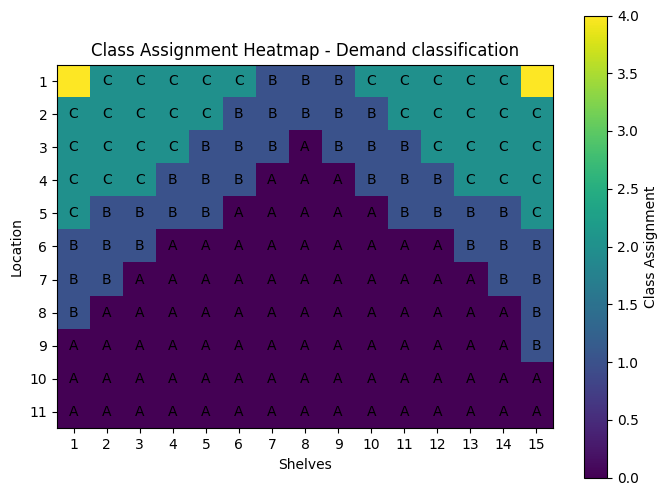

In [289]:
# Initialize a matrix to store class assignments for each station
class_matrix = np.zeros((11, 15), dtype=int)  # Assuming 11 shelves and 15 locations
tmp = 0

# Mapping dictionary for class indices to letters
class_letters = {0: 'A', 1: 'B', 2: 'C'}  # Add more mappings as needed

# Populate the class assignment matrix
for n in range(0, 11):  # assuming 11 shelves
    for m in range(0, 15):  # iterating through locations
        class_matrix[10 - n][m] = 4
        for c in range(len(classes)):
            if sol.get_value(xlc[tmp, c]) == 1:
                class_matrix[10 - n][m] = c  # Assign class index to matrix
        tmp += 1

# Create the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(class_matrix, cmap='viridis', interpolation='nearest')

# Add text annotations for class letters inside the cells
for i in range(11):
    for j in range(15):
        if class_matrix[i][j] in class_letters:
            plt.text(j, i, class_letters[class_matrix[i][j]], ha='center', va='center', color='black')

# Set axes labels
plt.xlabel('Shelves')
plt.ylabel('Location')

# Set colorbar
cbar = plt.colorbar()
cbar.set_label('Class Assignment')

# Set ticks for shelves and locations
plt.xticks(np.arange(15), np.arange(1, 16))
plt.yticks(np.arange(11), np.arange(1, 12))

plt.title('Class Assignment Heatmap - Demand classification')
plt.show()
